This is an introduction to the pitfalls of data mining in the context of financial backtests

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import pandas.io.data as web
import scipy.optimize
from mayavi import mlab
from IPython.display import Image
from itertools import product

The goal of this notebook is to explore different trading strategies for XIV (http://www.velocitysharesetns.com/xiv)
The idea is to start with some nieve entry and exit parameters and refine these until we find something that appears
to have some juice. The whole point of this exercise is to find a strategy that looks
appealing but is complete bogus, after all, if there was any juice I wouldn't be publishing this ;).

In [3]:
xiv = web.DataReader("XIV", "yahoo")

In [4]:
xiv.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-11-30,95.65,97.72,95.42,95.57,252000,9.56
2010-12-01,99.57,99.93,97.83,97.87,484000,9.79
2010-12-02,99.24,104.29,99.24,104.29,62000,10.43
2010-12-03,104.23,110.41,104.23,110.41,168000,11.04
2010-12-06,109.46,112.78,109.46,112.52,232000,11.25


In [5]:
xiv.drop(["High", "Low", "Volume", "Close"], axis=1, inplace=True)

In [6]:
# adjust historical opens for 10:1 split on June 27, 2010
xiv.loc[:"2011-06-24", "Open"] = xiv.loc[:"2011-06-24", "Open"] / 10

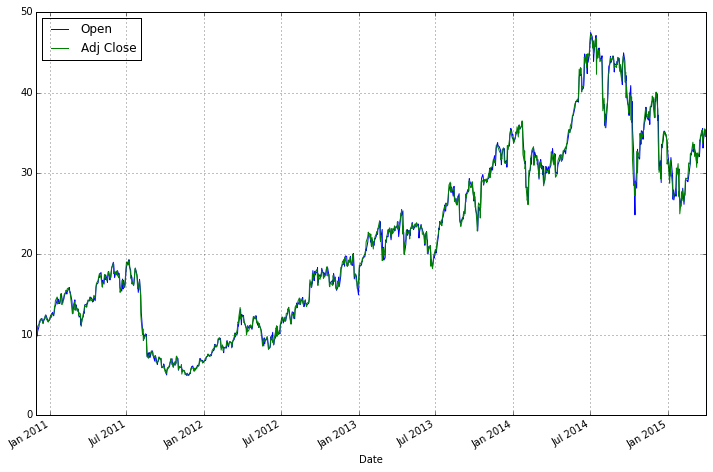

In [7]:
xiv.plot(figsize=(12,8))

### Calculate daily returns for different holding periods

In [8]:
# standard close to close returns
rets_Cl = (xiv["Adj Close"] - xiv["Adj Close"].shift(1)) / xiv["Adj Close"].shift(1)
# returns obtained for only only holding positons for the day
rets_day = (xiv["Adj Close"] - xiv["Open"]) / xiv["Open"]
rets = pd.concat([rets_Cl, rets_day], axis=1)
rets.columns = ["Close", "Day"]

### Split returns into in sample and out of sample components

In [9]:
spdate = "2014-06-01"
rets_IS = rets[:spdate]
rets_OS = rets[spdate:]

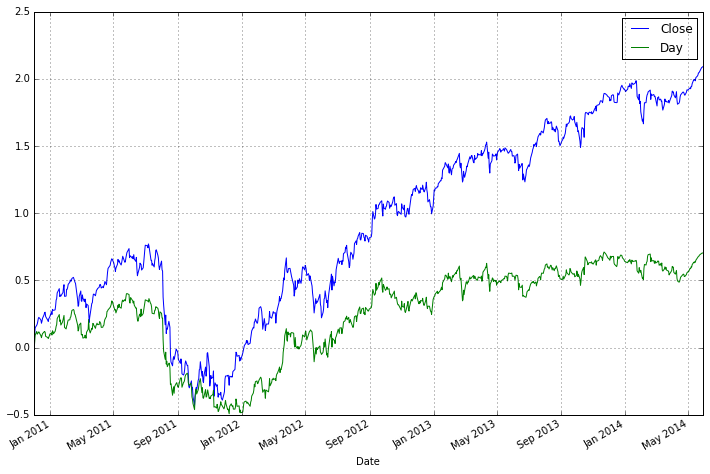

In [10]:
cumsum(rets_IS).plot(figsize=(12,8))

Define some performance metric
------------

We use IR here which is a common performance metric

In [11]:
def IR(df):
    ir = sqrt(252) * (np.mean(df) / np.std(df))
    # addresses strategies which are never invested
    if np.isnan(ir):
        ir = np.float64(0)
    return ir

In [12]:
rets_IS.apply(IR)

Close    0.967489
Day      0.410018
dtype: float64

Define a naive reversion strategy that buys the asset if its daily returns are less than  \`stdevs number
of standard deviations, where standard deviation is calculated using a rolling window of length \`std_win.
Hold the position for \`hwin number of days. The strategy is using open to close prices to make a decision at the close which has some look ahead bias however if we assume that the Close - $\epsilon$ is close enough to Close such that the signal is unchanged (which is a reasonable assumption) then in practice we could achieve this result by using some price slightly before the close. This also ignores important details like tcosts.

In [13]:
def rev_strat(ser, std_win=30, stdevs=1.5, hwin=1):
    hwin = int(hwin)
    stds = pd.stats.moments.rolling_std(ser, std_win)
    sig = 1*(ser < -stdevs*stds)
    hsig = sig.copy()
    idx = 0
    while idx <= len(sig)-1:
        if sig[idx] == 1:
            hsig[idx:idx+hwin] = 1
            idx = idx + hwin - 1
        idx += 1
    return hsig

In [14]:
sig = rev_strat(rets_IS["Day"])

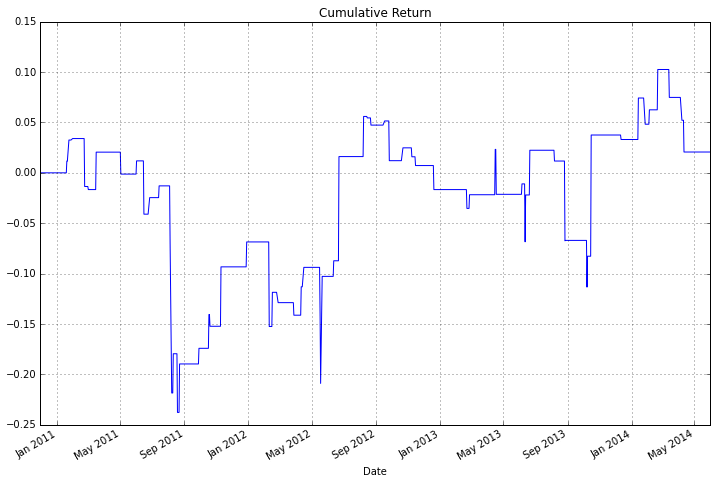

In [15]:
# signal needs to be lagged by a day to avoid look ahead bias since we are using the Open to Close which
# overlaps with the Close to Close
rev_rets = sig.shift(1)*rets_IS["Close"]
cumsum(rev_rets).plot(figsize=(12, 8))
plt.title("Cumulative Return")

Even without calculating performance metrics, you probably would realize you don't
want to trade this strategy, but just for fun

In [16]:
print(IR(rev_rets))

0.0305600321502


In [17]:
def f(x, *params):
    std_win, stdevs, hwin = x
    ser, rets = params
    ir_val = IR((rev_strat(ser, std_win, stdevs, hwin).shift(1)*rets))
    return -ir_val

In [18]:
rranges = (slice(2, 91, 1), slice(1, 3.25, 0.25), slice(1, 31, 1))
params = (rets_IS["Day"], rets_IS["Close"])

In [19]:
%timeit f((30, 1.5, 1), *params)

100 loops, best of 3: 16.5 ms per loop


The code below is fairly slow, on my machine it takes ~6.6 mins (89 \* 9 \* 31 \* 0.0161 / 60)

In [20]:
grid_vals = scipy.optimize.brute(f, rranges, args=params, full_output=True)

Since scipy.optimize.brute minimizes a function, we have defined f as a function which returns negative IR,
the optimal -IR for this strategy is show below

In [21]:
grid_vals[0]

array([  6.,   1.,  16.])

For the optimal signal, the path of cumulative returns is calculated

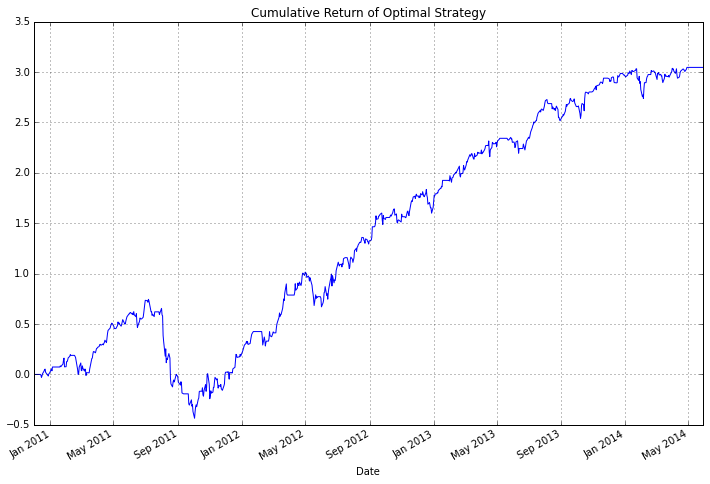

In [22]:
sig_opt = rev_strat(rets_IS["Day"], grid_vals[0][0], grid_vals[0][1], grid_vals[0][2])
# signal needs to be lagged by a day to avoid look ahead bias since we are using the Open to Close which
# overlaps with the Close to Close
rev_opt_rets = sig_opt.shift(1)*rets_IS["Close"]
cumsum(rev_opt_rets).plot(figsize=(12, 8))
plt.title("Cumulative Return of Optimal Strategy")

In [23]:
irs = grid_vals[3].copy()
irs[irs == 100] = 0
irs = -irs
b1 = np.percentile(irs, 20)
b2 = np.percentile(irs, 80)
mlab.pipeline.volume(mlab.pipeline.scalar_field(irs), vmin=b1, vmax=b2)
mlab.axes(xlabel="Std Window", ylabel="Std Threshold", zlabel="Holding Period")
mlab.colorbar()
mlab.show()

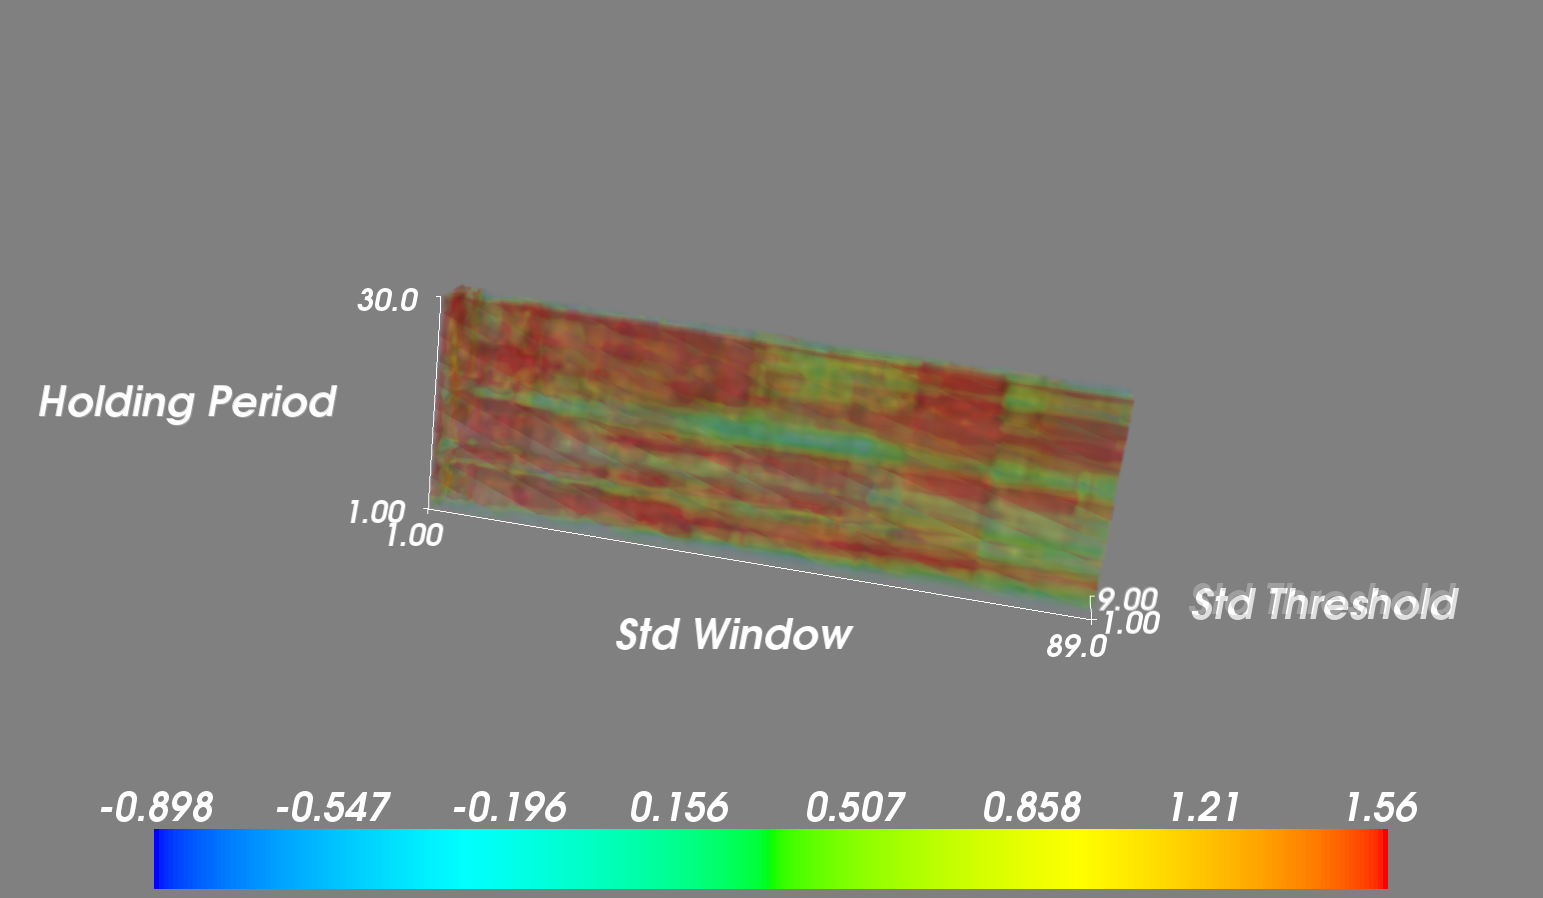

In [24]:
Image('sensitivity.png', width=950)

The idea with the graph above was to get a feel for how sensitive the IR was with respect to different parameter specifications, although admittedly this graph isn't very informative. The colorbar indicates the IR of the strategy for different parameter choices. The most sensitive choice is holding period, since there are sharp transitions across this axis. Another approach to check the stability of the model would be to perturb the optimal parameter choice (6, 1, 16) and examine the effects.

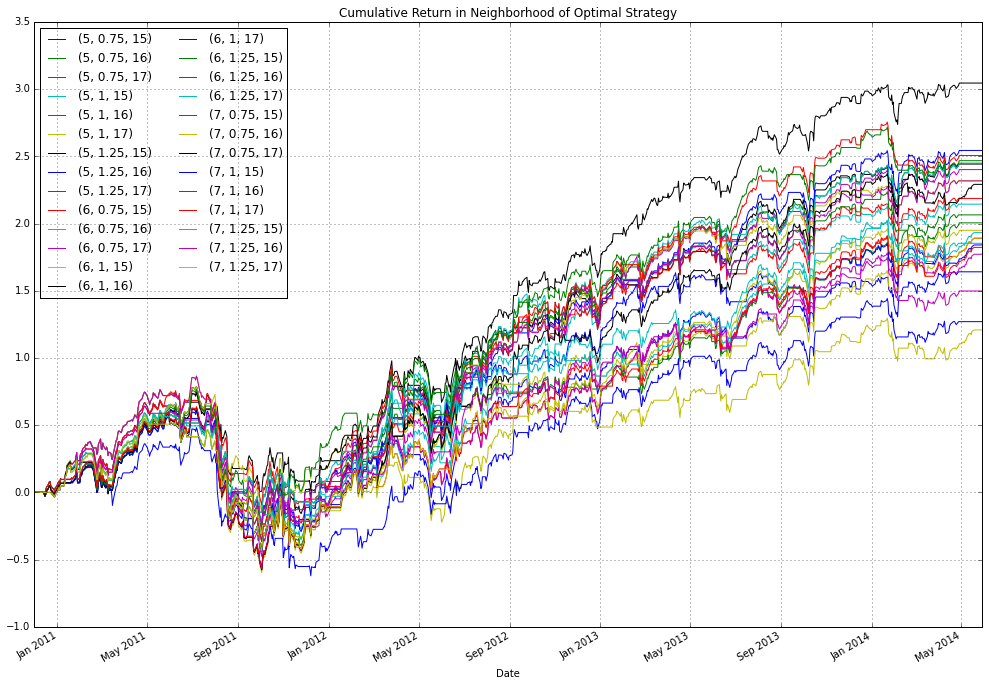

In [25]:
stdwins = [5,6,7]
stddevs = [0.75, 1, 1.25]
hwins = [15, 16, 17]

df = pd.DataFrame()
for i, params in enumerate(product(stdwins, stddevs, hwins)):
    sig = rev_strat(rets_IS["Day"], params[0], params[1], params[2])
    rev_rets = sig.shift(1)*rets_IS["Close"]
    df[params] = rev_rets

cumsum(df).plot(figsize=(17, 12))
plt.legend(loc='upper left', ncol=2)
plt.title("Cumulative Return in Neighborhood of Optimal Strategy")


Out of Sample
--------

Another way to determine whether a strategy performs well is to check the performance out of sample. Since we have deligently seperated our returns into two buckets, we can take the parameters chosen over the first subsample and evaluate the performance of the specified strategy on the second set of returns. As expected, the model performs terribly.

In [26]:
sig_os = rev_strat(rets_OS["Day"], 6, 1, 16)
rev_rets_os = sig_os.shift(1)*rets_OS["Close"]
IR(rev_rets_os)

0.22769032485813084

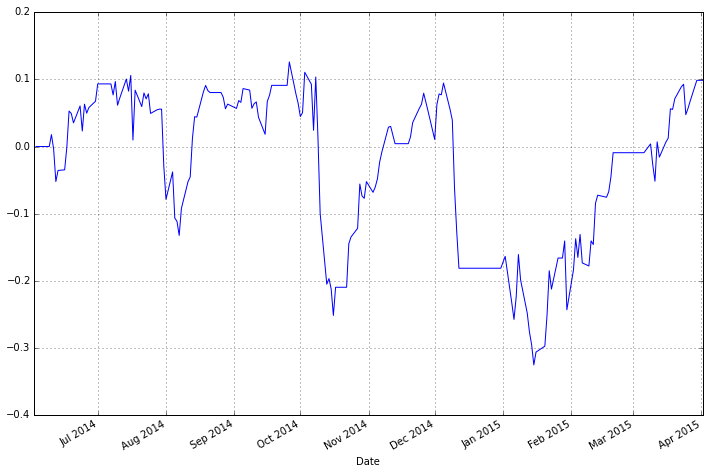

In [27]:
cumsum(rev_rets_os).plot(figsize=(12, 8))